In [1]:
from bertopic import BERTopic
import cudf as pd
from sentence_transformers import SentenceTransformer
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.preprocessing.text.stem import PorterStemmer
from cuml import IncrementalPCA
from cuml.random_projection import SparseRandomProjection
import seaborn as sns
import statsmodels.api as sm
import numpy as np
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
from pprint import pprint

/home/jcosme/miniconda3/envs/naba/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# input file
input_filename = './output_files/naba_data_removed_duplicates.csv'

# some column names
txt_col = "Copy/ PasteÂ An Essay Response of 500 words or less (copy and paste in webform) using the following prompt: Community disruptions such as Covid-19 and other natural disasters can have deep lasting impacts. Discuss a challenge or barrier you have overcome during the Covid-19 pandemic."
label_col = 'Recipient'

# output files
norm_topic_count_filename = './output_files/norm_topic_count_df.csv'
decrease_chances_sencs_filename = './output_files/decrease_chances_sencs.csv'
increase_chances_sencs_filename = './output_files/increase_chances_sencs.csv'
bottom_k_sencs_filename = './output_files/bottom_k_sencs.csv'
top_k_sencs_filename = './output_files/top_k_sencs.csv'

In [3]:
random_seed = 42

sentence_model = SentenceTransformer(
    "all-mpnet-base-v2", 
    device="cuda",
)

umap = IncrementalPCA(
    n_components=1,
    whiten=True,
)


topic_model = BERTopic(
    embedding_model=sentence_model,
    top_n_words=6, 
    diversity=1,
    n_gram_range=(1, 1),
    min_topic_size=10,
    nr_topics='auto',
    umap_model=umap,
)

p_alpha = 0.1
k_topics = 5

In [4]:
df = pd.read_csv(input_filename)

In [5]:
df.head()

app_id  \
0       0   
1       1   
2       2   
3       3   
4       4   

  Gender:* Required fields are indicated with red symbol Permanent Contact Information  \
0                                               Male                                     
1                                             Female                                     
2                                             Female                                     
3                                             Female                                     
4                                               Male                                     

  City (Permanent):* Required fields are indicated with red symbol Permanent Contact Information   \
0                                           Brooklyn                                                
1                                              Bowie                                                
2                                    Chicago Heights                                                
3                                            Chicago                                                
4                                        Baton Rouge                                                

  State (Permanent):* Required fields are indicated with red symbol Permanent Contact Information  \
0                                                 NY                                                
1                                                 MD                                                
2                                                 IL                                                
3                                                 IL                                                
4                                                 LA                                                

  Zip (Permanent):* Required fields are indicated with red symbol Permanent Contact Information  \
0                                              11216                                              
1                                              20720                                              
2                                              60411                                              
3                                              60620                                              
4                                              70806                                              

  Are you Black? (includes African, African American, Caribbean, etc.)  \
0                                                Yes                     
1                                                Yes                     
2                                                Yes                     
3                                                Yes                     
4                                                Yes                     

  Preferred Mailing Address  College/University:Academic Profile  \
0                 Permanent                 Medgar Evers College   
1                 Permanent               University of Maryland   
2                 Permanent  North Carolina A&T State University   
3                 Permanent            Loyola University Chicago   
4          Campus/Temporary                Penn State University   

  Classification (as of January 2022):Academic Profile Major:Academic Profile  \
0                                             Senior               Accounting   
1                                           Freshman      Business Management   
2                                           Freshman               Accounting   
3                                          Sophomore               Accounting   
4                                          Sophomore               Accounting   

   ... Please provide details (i.e. company name, location, etc.)  \
0  ...                                               <NA>           
1  ...  Received internship as a Summer 2022 Discovery...           
2  ...                    

## Topic modeling

In [6]:
# correct the labels column
labels_df = df[label_col].copy()
labels_df

0      <NA>
1      <NA>
2      <NA>
3      <NA>
4       Yes
       ... 
195     Yes
196    <NA>
197    <NA>
198    <NA>
199     Yes
Name: Recipient, Length: 200, dtype: object

In [7]:
labels_df[labels_df.notnull()] = 1.0
labels_df

0      <NA>
1      <NA>
2      <NA>
3      <NA>
4       1.0
       ... 
195     1.0
196    <NA>
197    <NA>
198    <NA>
199     1.0
Name: Recipient, Length: 200, dtype: object

In [8]:
labels_df[labels_df.isna()] = 0.0
labels_df = labels_df.astype('float')
labels_df

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
195    1.0
196    0.0
197    0.0
198    0.0
199    1.0
Name: Recipient, Length: 200, dtype: float64

In [9]:
labels_df.value_counts()

1.0    110
0.0     90
Name: Recipient, dtype: int32

In [10]:
df[label_col] = labels_df

In [11]:
# normalize spaces: Remove extra whitespace between tokens and trim whitespace from the beginning and the end of each string.
df[txt_col] = df[txt_col].str.normalize_spaces()

In [12]:
# create a colum for how many words in each paragraph
df['txt_len'] = df[txt_col].str.split().list.len()

In [13]:
# replace any 'N/A' values with empty strings
total_na = df[txt_col].copy().isna().sum()
print(f"total empty count: {total_na}")
print(df.loc[df[txt_col].isna(), txt_col])
df.loc[df[txt_col].isna(), txt_col] = ''
total_na = df[txt_col].copy().isna().sum()
print(f"new total empty count: {total_na}")

total empty count: 1
    Copy/ PasteÂ An Essay Response of 500 words or less (copy and paste in webform) using the following prompt: Community disruptions such as Covid-19 and other natural disasters can have deep lasting impacts. Discuss a challenge or barrier you have overcome during the Covid-19 pandemic.
146                                               <NA>                                                                                                                                                                                                                                          
new total empty count: 0


In [14]:
# df

In [15]:
# split each paragraph into sentences
sentences_df = df[txt_col].copy() + ' '
sentences_df = sentences_df.str.replace('Dr.', 'doctor', regex=False) # I saw this abbreviation so i'm just replacing it
senc_per_paragraph = sentences_df.str.split(pat='[!.?] ', regex=True).list.len()
sentences_df = sentences_df.str.split(pat='[!.?] ', regex=True, expand=True) # we assume sentences end in '.' '?' or '!' so we split on these
sentences_df = sentences_df.fillna('') # replace NA with empty strings
max_n_sencs = sentences_df.shape[1]
n_rows = sentences_df.shape[0]
sentences_df

0   \
0    During the early parts of 2020 one of the dead...   
1    One of the most challenging times has been dur...   
2    When covid restrictions took place I was just ...   
3    When the Covid-19 pandemic first began, I was ...   
4    Community disruptions such as Covid-19 and oth...   
..                                                 ...   
195  There are many issues that are impacting the a...   
196  My name is Wunmi Surakat, a current 1st semest...   
197             No one expected the Covid- 19 pandemic   
198  During the COVID-19 pandemic, my entire life c...   
199  The Covid-19 pandemic is something that has af...   

                                                    1   \
0    This pandemic has bedeviled me with many hurdl...   
1    It truly had an impact on my family emotionall...   
2    In March of 2020, that was the last time I wou...   
3    In the Fall of 2020, I started college with th...   
4    The Covid-19 pandemic has taught us that disru...   
..                                                 ...   
195  I believe one of the most important issues is ...   
196  At the start of the COVID-19 pandemic, I was i...   
197  Since it happened it has opened my eyes and ma...   
198  I made an 180 degree turn in my life, finally ...   
199  As a recent graduate and being in the first se...   

                                                    2   \
0    The most difficult barrier I've had to overcom...   
1    My father lost his employment in an industry t...   
2    Because of the coronavirus people began to los...   
3    Starting my first year of college online made ...   
4    As such, we are to remain vigilant and always ...   
..                                                 ...   
195  When talking about, Covid-19 it has impacted m...   
196  I remembered clearly, I was on Spring Break in...   
197  The pandemic has affected my life in many ways...   
198  I went from extremely motivated, bubbly, energ...   
199  I came to college in 2018, so I only had one i...   

                                                    3   \
0    As an international transfer student from Guya...   
1      This did have a significant burden on my family   
2    So, here I am about seventeen years old, worki...   
3    Instead, I was faced with attending classes on...   
4                  Covid-19 has had a big impact on me   
..                                                 ...   
195  Challenges and barriers that I have had to ove...   
196  After spring break was over, all my classes we...   
197  One challenge that I had to face was my bigges...   
198  I moved from across the country to a universit...   
199  When I first came to college, I was always the...   

                                                    4   \
0    I only had the privilege to experience what it...   
1    Additionally, I developed Covid-19 this fall s...   
2    I ended up quitting sports and extra activitie...   
3    With Zoom, it was a rocky start with getting u...   
4    I have been affected financially, psychologica...   
..                                                 ...   
195     Learning is an essential part of everyday life   
196  Learning online became the biggest challenge a...   
197  I had a fear of going to college because at th...   
198  I faced several low points in my life during t...   
199  When my university went virtual, that took awa...   

                                                    5   \
0    Never in my life prior to covid have I taken a...   
1    This did have an impact on my GPA and caused m...   
2    This was extremely hard for me because in Marc...   
3    It was also much more difficult to really enjo...   
4    Like many other students, I painfully grappled...   
..                                                 ...   
195  It is the process behind acquiring a new under...   
196  For the past 18years of my life, I had In-pers...   
197  After losing my mother at such an early 

In [16]:
# stack all the sentences into one column
sentences_series = sentences_df.copy().stack().reset_index(drop=True)
sentences_series = sentences_series.str.normalize_spaces()
sentences_series

0       During the early parts of 2020 one of the dead...
1       This pandemic has bedeviled me with many hurdl...
2       The most difficult barrier I've had to overcom...
3       As an international transfer student from Guya...
4       I only had the privilege to experience what it...
                              ...                        
8595                                                     
8596                                                     
8597                                                     
8598                                                     
8599                                                     
Length: 8600, dtype: object

In [17]:
# preprocess the sentences:
# 1. remove all non-letter character
# 2. remove all english 'stop words' (words like 'the' 'I' 'may' 'this' 'him' basically words that don't add meaning to sentences
# 3. stem all words (for example 'moving', 'moved', and 'move' would all be changed to 'mov'

# load word stemmer 
stemmer = PorterStemmer()
# get stop words from tfidf
tfidf = TfidfVectorizer(stop_words='english')
stop_words = tfidf._get_stop_words() # stop words will be removed
del tfidf

def preproc_senc_srs(a_series):
    preproc_sentences_series = a_series.copy()
    
    # remove all non-alpbabet characters
    preproc_sentences_series = preproc_sentences_series.str.normalize_spaces().str.lower().str.replace('[^A-Za-z\s]', '', regex=True)
    
    # remove each stop word
    for stop_word in stop_words:
        preproc_sentences_series = preproc_sentences_series.str.replace(fr'\b{stop_word}\b', '', regex=True)
        
    # stem each word
    preproc_sentences_series = preproc_sentences_series.str.normalize_spaces()
    preproc_sentences_series = preproc_sentences_series + ' -'
    sen_lens = preproc_sentences_series.str.split().list.len()
    sen_index = sen_lens.index.repeat(sen_lens)
    preproc_sentences_series = stemmer.stem(preproc_sentences_series.str.tokenize()).str.detokenize(sen_index)
    preproc_sentences_series = preproc_sentences_series.str.replace('-', '')
    preproc_sentences_series = preproc_sentences_series.str.normalize_spaces()
    
    return preproc_sentences_series

In [18]:
preproc_sentences_series = preproc_senc_srs(sentences_series)

In [19]:
preproc_sentences_series 

0       earli part deadliest virus plagu world novel c...
1         pandem bedevil hurdl overcom drastic chang life
2       difficult barrier ive overcom get simul new co...
3       intern transfer student guyana extrem difficul...
4       privileg experi felt like attend class campu m...
                              ...                        
8595                                                     
8596                                                     
8597                                                     
8598                                                     
8599                                                     
Length: 8600, dtype: object

In [20]:
# get the labels
y_series = sentences_df.copy().set_index(df[label_col])
y_series = y_series.stack().reset_index().sort_values('level_1')[preproc_sentences_series.str.len() != 0]['level_0'].astype(int)
y_series

0       0
43      0
86      0
129     0
172     1
       ..
7223    1
7266    1
7309    0
7352    1
7395    1
Name: level_0, Length: 4019, dtype: int64

In [21]:
# drop all empty rows for fitting model
docs = preproc_sentences_series[preproc_sentences_series.str.len() != 0]
docs

0       earli part deadliest virus plagu world novel c...
1         pandem bedevil hurdl overcom drastic chang life
2       difficult barrier ive overcom get simul new co...
3       intern transfer student guyana extrem difficul...
4       privileg experi felt like attend class campu m...
                              ...                        
8567    feel unmotiv taken toll mental health way caus...
8568    overcom challeng thought barrier success push ...
8569    famili colleg path corpor world creat legaci f...
8570    continu strive new height daili reach potenti ...
8571    understand purpos challeng face allow experi m...
Length: 4019, dtype: object

In [22]:
# turn Series into a list; move from GPU to CPU
docs = docs.to_arrow().to_pylist()
y = y_series.to_arrow().to_pylist()

In [23]:
# fit the topic model
topic_model.fit(docs, y=y)

In [24]:
# show topics and topic counts 
topic_model.get_topic_info()

Topic  Count                                     Name
0      -1    690              -1_student_covid_peopl_make
1       0    852                 0_pandem_school_did_year
2       1    219                1_covid_chang_famili_know
3       2     93              2_clinic_limit_safeti_wasnt
4       3     74                  3_kloot_amanda_wifi_neg
..    ...    ...                                      ...
70     69     13  69_offer_povertystricken_upcom_michigan
71     70     12            70_encamp_stop_hope_technolog
72     71     11           71_curfew_lower_embassi_tragic
73     72     11       72_oneweek_explan_dormitori_preval
74     73     10              73_scenic_save_teacher_well

[75 rows x 3 columns]

In [25]:
n_topics = topic_model.get_topic_info().shape[0] - 1
n_topics

74

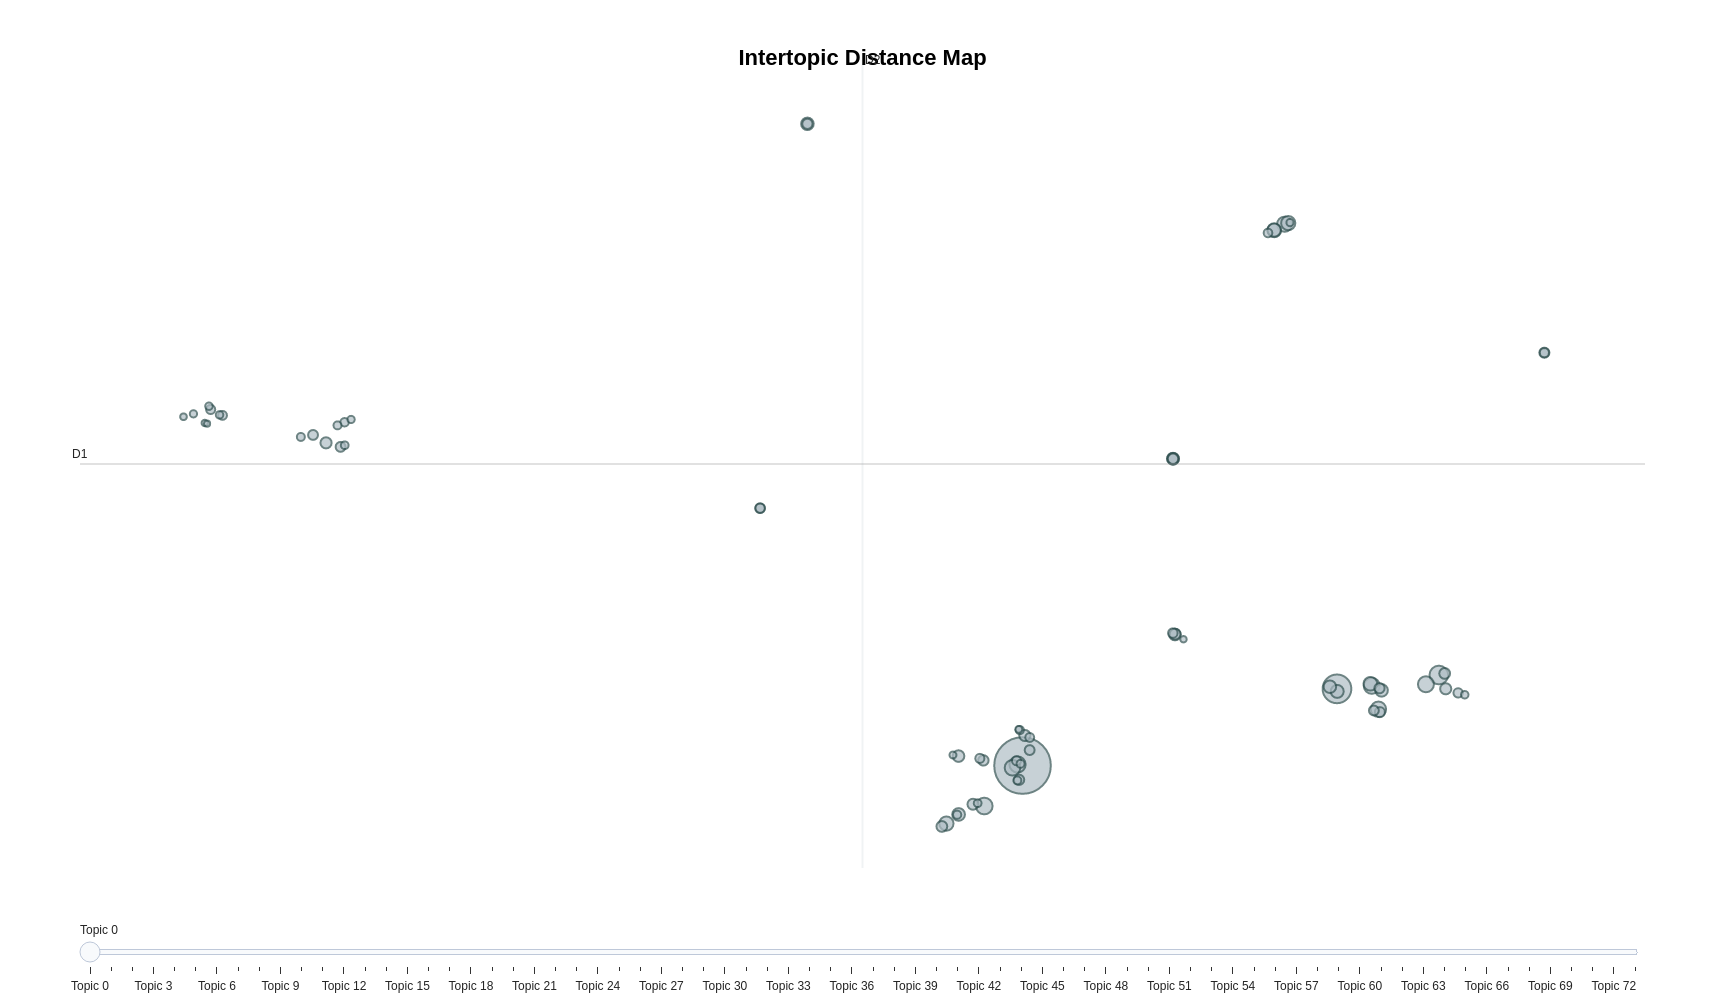

In [26]:
# plot topic distance map
topic_model.visualize_topics(width=1000, height=1000)

In [27]:
# save plot of topic distance map
topic_model.visualize_topics(width=1000, height=1000).write_html("./visualizations/visualize_topics.html")

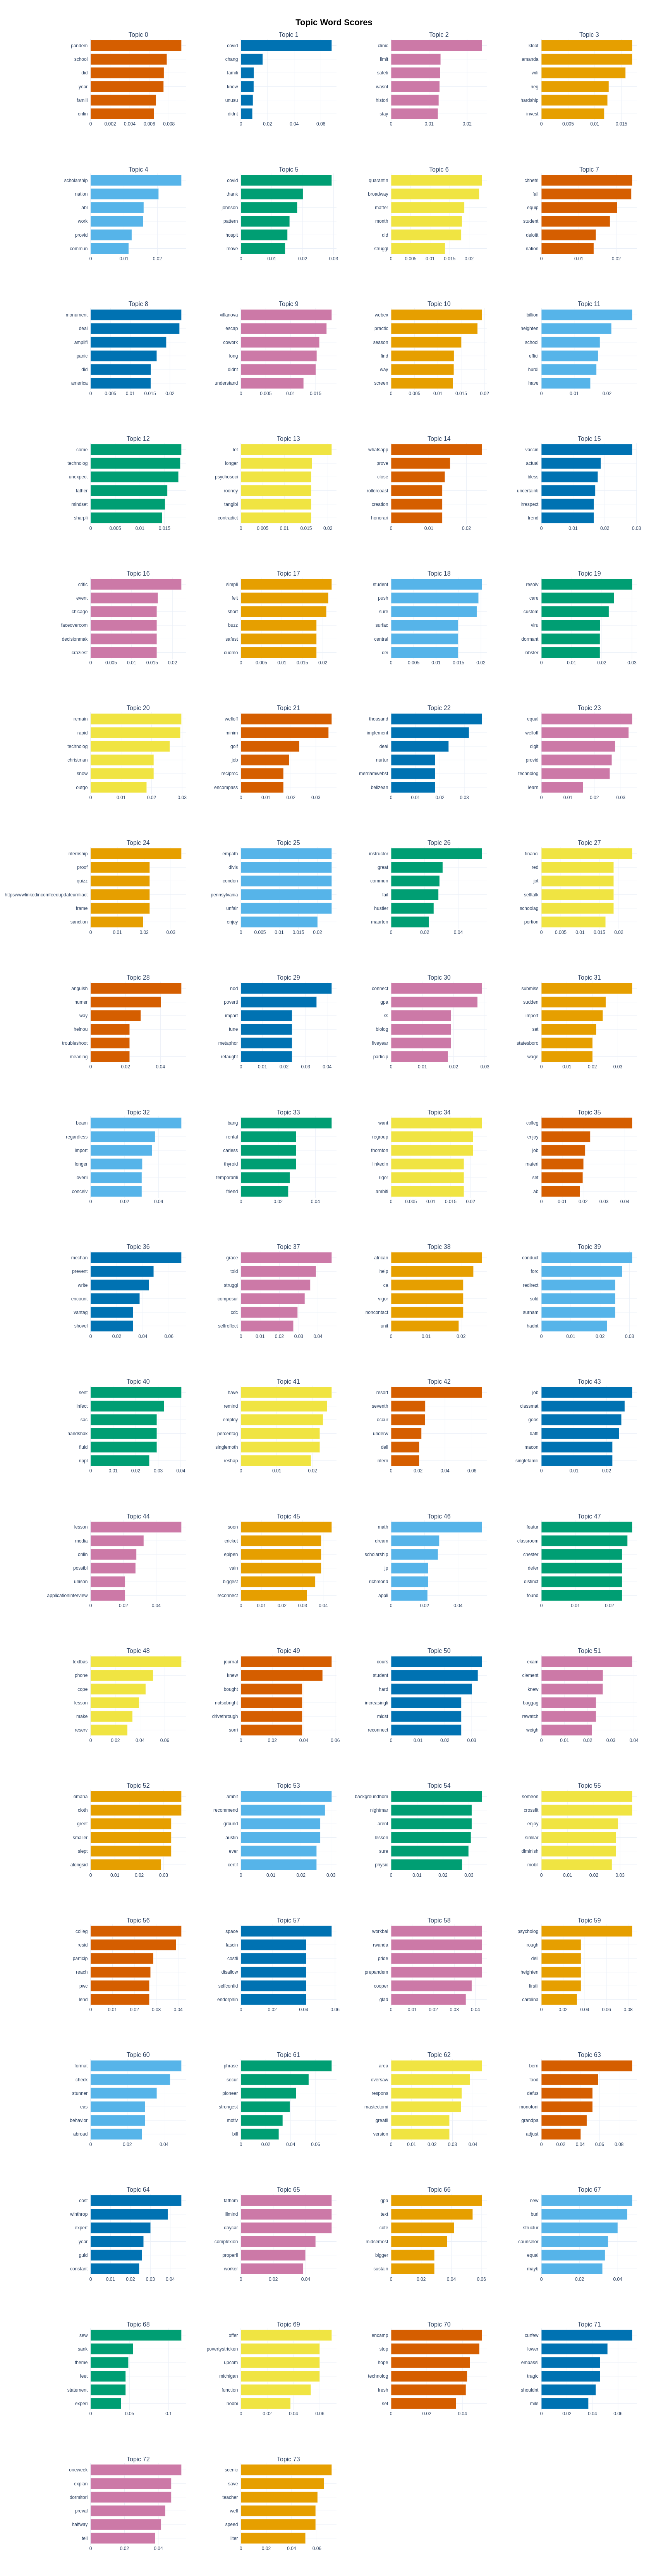

In [28]:
# show words for each topic
topic_model.visualize_barchart(top_n_topics=topic_model.get_topic_info().shape[0], n_words=10, height=350, width=400)

In [29]:
# save plot of words for each topic
topic_model.visualize_barchart(top_n_topics=topic_model.get_topic_info().shape[0], n_words=10, height=350, width=400).write_html('./visualizations/visualize_barchart.html')

In [30]:
# label each sentence with a topic
docs = preproc_sentences_series.to_arrow().to_pylist()
doc_topics, topic_probs = topic_model.transform(docs)

In [31]:
# perform topic hierarchy analysis
docs = preproc_sentences_series[preproc_sentences_series.str.len() != 0]
docs = docs.to_arrow().to_pylist()
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|███████████████████████████████████████████| 73/73 [00:01<00:00, 45.56it/s]


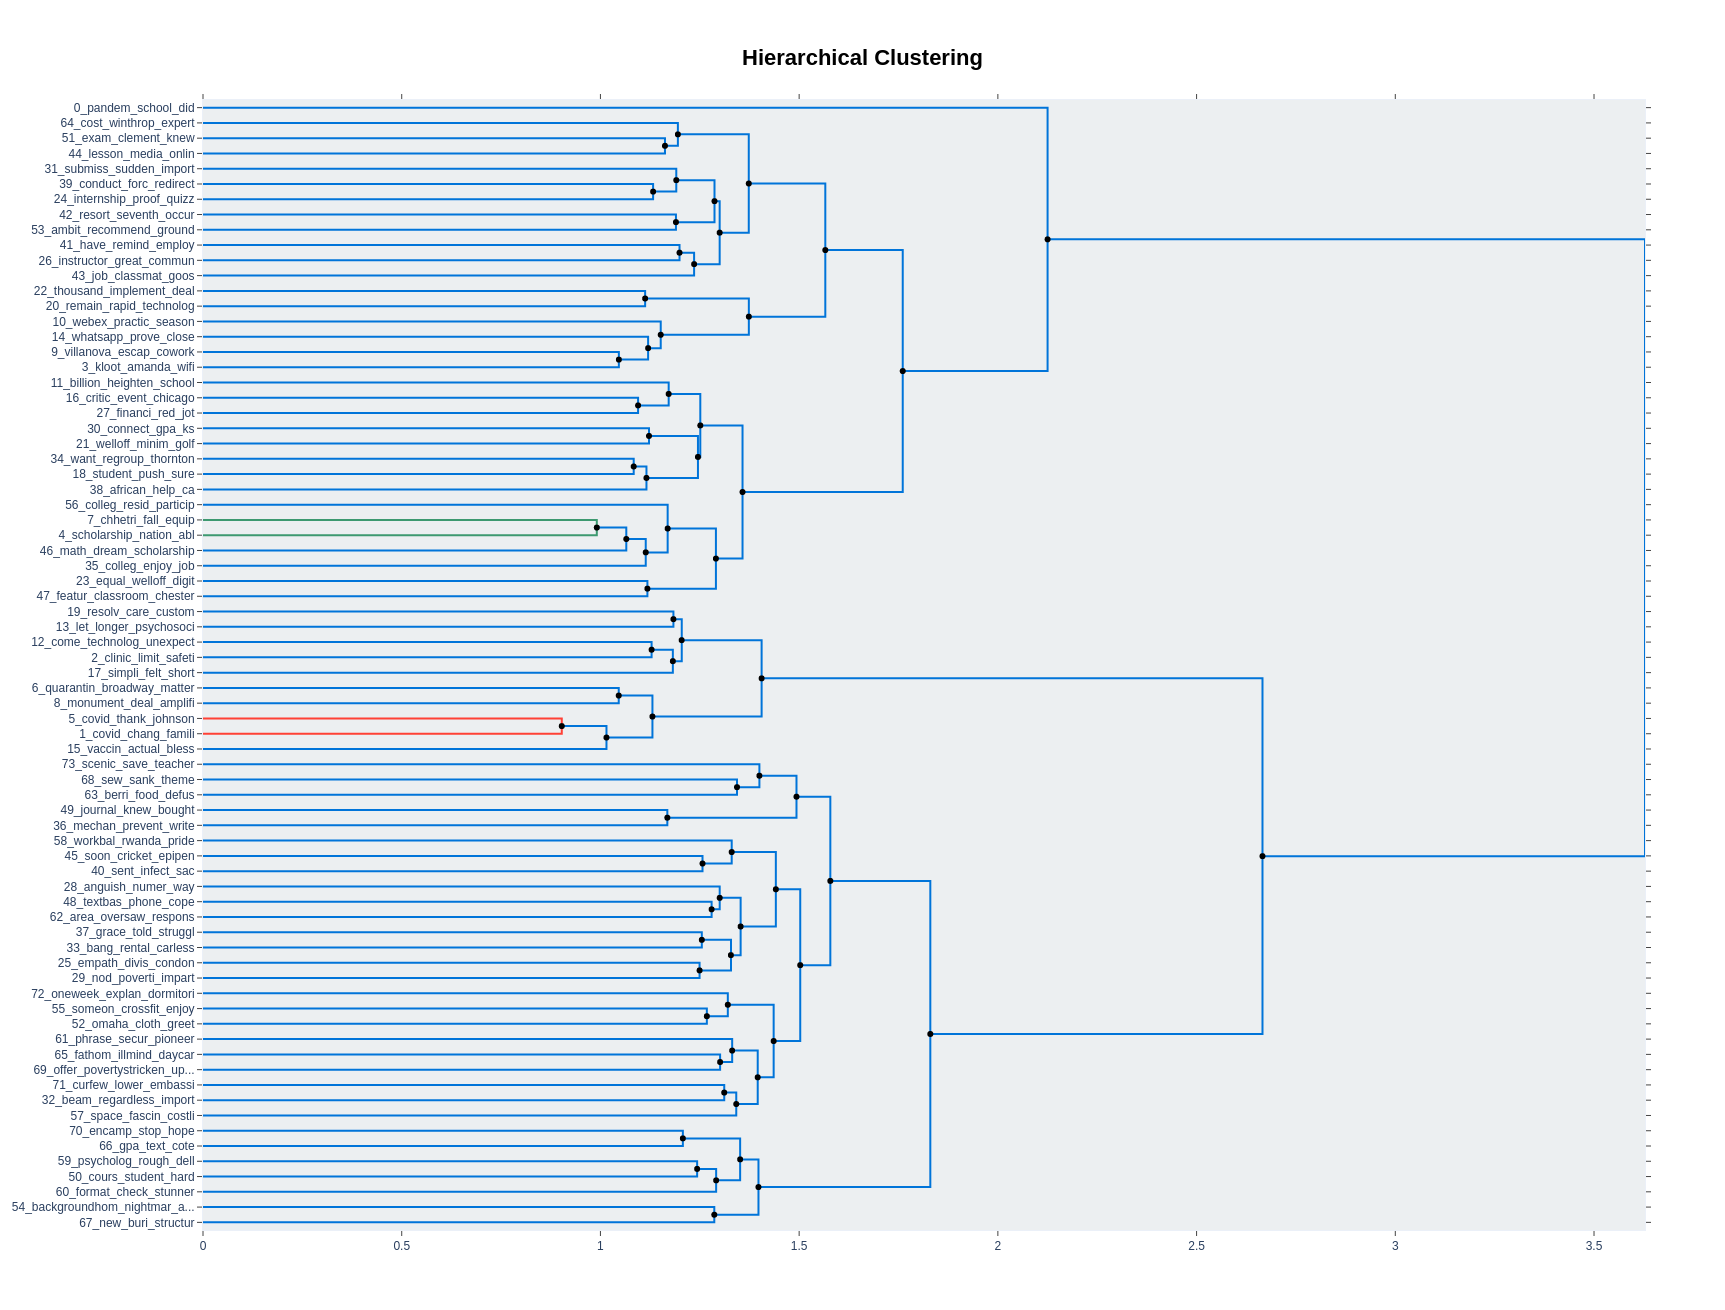

In [32]:
# plot topic hierarchy
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [33]:
# save plot of topic hierarchy
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics).write_html('./visualizations/visualize_heirarchy.html')

In [34]:
# create a dataframe that categorizes each sentence
topics_series = pd.Series(doc_topics).astype(str)

col_index = []
for i in range(n_rows):
    col_index.extend([i] * max_n_sencs)
    
senc_topics_df = topics_series.str.detokenize(pd.Series(col_index)).str.split(expand=True)
senc_topics_df = senc_topics_df.rename(columns={x: f'senc_{str(x)}' for x in senc_topics_df.columns})
senc_topics_df

senc_0 senc_1 senc_2 senc_3 senc_4 senc_5 senc_6 senc_7 senc_8 senc_9  \
0        1      8      0      3     -1      0      0      4     -1     28   
1        5      3      0     40     36      0     -1      0      0      4   
2        0     20      0     24     23      0      0     -1     24     -1   
3       16     -1     -1     21     -1      4     69     72     31     -1   
4        1      1      8     -1     -1      0      0      0     70      7   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
195     -1     40     12     12     59     60     38     70     -1     39   
196      0      8     11     11     -1      9     47     10     67     16   
197      1      3     40     31     53     69      0     53     35     20   
198      1     45     41      0      0     45     21      0     -1     33   
199     19      0     35     18     21      7     35     46      3     23   

     ... senc_33 senc_34 senc_35 senc_36 senc_37 senc_38 senc_39 senc_40  \
0    ...      -1      -1      -1      -1      -1      -1      -1      -1   
1    ...      -1      -1      -1      -1      -1      -1      -1      -1   
2    ...      -1      -1      -1      -1      -1      -1      -1      -1   
3    ...      -1      -1      -1      -1      -1      -1      -1      -1   
4    ...      -1      -1      -1      -1      -1      -1      -1      -1   
..   ...     ...     ...     ...     ...     ...     ...     ...     ...   
195  ...      -1      -1      -1      -1      -1      -1      -1      -1   
196  ...      -1      -1      -1      -1      -1      -1      -1      -1   
197  ...      -1      -1      -1      -1      -1      -1      -1      -1   
198  ...      -1      -1      -1      -1      -1      -1      -1      -1   
199  ...      -1      -1      -1      -1      -1      -1      -1      -1   

    senc_41 senc_42  
0        -1      -1  
1        -1      -1  
2        -1      -1  
3        -1      -1  
4        -1      -1  
..      ...     ...  
195      -1      -1  
196      -1      -1  
197      -1      -1  
198      -1      -1  
199      -1      -1  

[200 rows x 43 columns]

In [35]:
# count of each topic per paragraphs

topic_count_df = pd.DataFrame(index=range(n_rows), columns=range(n_topics))
for i in range(n_rows):
    temp_df = senc_topics_df.iloc[i].reset_index(drop=True).T.value_counts().sort_index().to_frame().T
    temp_df = temp_df[temp_df.columns[1::]]
    temp_df.columns = temp_df.columns.to_frame()[0].values
    topic_count_df.loc[i, temp_df.columns.astype(int)] = temp_df.values.flatten()
topic_count_df = topic_count_df.fillna(0)
topic_count_df = topic_count_df.rename(columns={x: f'topic_{str(x)}' for x in topic_count_df.columns})
topic_count_df


topic_0 topic_1 topic_2 topic_3 topic_4 topic_5 topic_6 topic_7 topic_8  \
0         5       1       0       1       1       0       1       0       1   
1         5       0       0       1       1       1       0       0       0   
2         4       0       0       0       0       0       0       0       0   
3         1       0       0       0       1       0       0       0       0   
4        10       5       0       2       0       1       0       1       1   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
195       1       0       0       0       0       0       0       0       0   
196       4       1       0       0       0       0       1       0       1   
197       4       1       0       1       0       0       0       0       0   
198       9       1       2       0       0       0       0       0       0   
199       2       0       0       1       0       0       0       1       0   

    topic_9  ... topic_64 topic_65 topic_66 topic_67 topic_68 topic_69  \
0         0  ...        0        0        0        0        0        0   
1         0  ...        0        0        0        0        0        0   
2         0  ...        0        0        0        0        0        0   
3         0  ...        0        0        0        0        0        1   
4         0  ...        0        0        0        0        0        0   
..      ...  ...      ...      ...      ...      ...      ...      ...   
195       0  ...        1        0        0        0        0        0   
196       1  ...        0        0        0        1        0        0   
197       0  ...        0        0        0        0        0        1   
198       0  ...        0        0        0        0        0        0   
199       0  ...        0        0        0        0        0        0   

    topic_70 topic_71 topic_72 topic_73  
0          0        0        0        1  
1          0        0        0        0  
2          0        0        0        0  
3          0        0        1        0  
4          1        0        0        0  
..       ...      ...      ...      ...  
195        2        0        0        0  
196        0        0        0        0  
197        0        0        0        0  
198        0        0        0        0  
199        0        0        0        0  

[200 rows x 74 columns]

In [36]:
# normalize each topic count by number of sentences in paragraphs
norm_topic_count_df = topic_count_df.astype('float')# + 1e-8
for a_col in norm_topic_count_df.columns:
    norm_topic_count_df[a_col] = norm_topic_count_df[a_col] / senc_per_paragraph
norm_topic_count_df[norm_topic_count_df.isna()] = 0
norm_topic_count_df

topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0    0.263158  0.052632  0.000000  0.052632  0.052632  0.000000  0.052632   
1    0.416667  0.000000  0.000000  0.083333  0.083333  0.083333  0.000000   
2    0.363636  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3    0.055556  0.000000  0.000000  0.000000  0.055556  0.000000  0.000000   
4    0.333333  0.166667  0.000000  0.066667  0.000000  0.033333  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.043478  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
196  0.181818  0.045455  0.000000  0.000000  0.000000  0.000000  0.045455   
197  0.173913  0.043478  0.000000  0.043478  0.000000  0.000000  0.000000   
198  0.321429  0.035714  0.071429  0.000000  0.000000  0.000000  0.000000   
199  0.125000  0.000000  0.000000  0.062500  0.000000  0.000000  0.000000   

      topic_7   topic_8   topic_9  ...  topic_64  topic_65  topic_66  \
0    0.000000  0.052632  0.000000  ...  0.000000       0.0       0.0   
1    0.000000  0.000000  0.000000  ...  0.000000       0.0       0.0   
2    0.000000  0.000000  0.000000  ...  0.000000       0.0       0.0   
3    0.000000  0.000000  0.000000  ...  0.000000       0.0       0.0   
4    0.033333  0.033333  0.000000  ...  0.000000       0.0       0.0   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.000000  0.000000  0.000000  ...  0.043478       0.0       0.0   
196  0.000000  0.045455  0.045455  ...  0.000000       0.0       0.0   
197  0.000000  0.000000  0.000000  ...  0.000000       0.0       0.0   
198  0.000000  0.000000  0.000000  ...  0.000000       0.0       0.0   
199  0.062500  0.000000  0.000000  ...  0.000000       0.0       0.0   

     topic_67  topic_68  topic_69  topic_70  topic_71  topic_72  topic_73  
0    0.000000       0.0  0.000000  0.000000       0.0  0.000000  0.052632  
1    0.000000       0.0  0.000000  0.000000       0.0  0.000000  0.000000  
2    0.000000       0.0  0.000000  0.000000       0.0  0.000000  0.000000  
3    0.000000       0.0  0.055556  0.000000       0.0  0.055556  0.000000  
4    0.000000       0.0  0.000000  0.033333       0.0  0.000000  0.000000  
..        ...       ...       ...       ...       ...       ...       ...  
195  0.000000       0.0  0.000000  0.086957       0.0  0.000000  0.000000  
196  0.045455       0.0  0.000000  0.000000       0.0  0.000000  0.000000  
197  0.000000       0.0  0.043478  0.000000       0.0  0.000000  0.000000  
198  0.000000       0.0  0.000000  0.000000       0.0  0.000000  0.000000  
199  0.000000       0.0  0.000000  0.000000       0.0  0.000000  0.000000  

[200 rows x 74 columns]

In [37]:
norm_topic_count_df.to_csv(norm_topic_count_filename, index=False)

In [38]:
# # change count to binary value (1 means topic is included, 0 means topic is not included)
# topic_count_df = topic_count_df.astype('float')
# topic_count_df[topic_count_df > 1] = 1
# topic_count_df


# norm_topic_count_df = topic_count_df.copy()
# norm_topic_count_df

<AxesSubplot: >

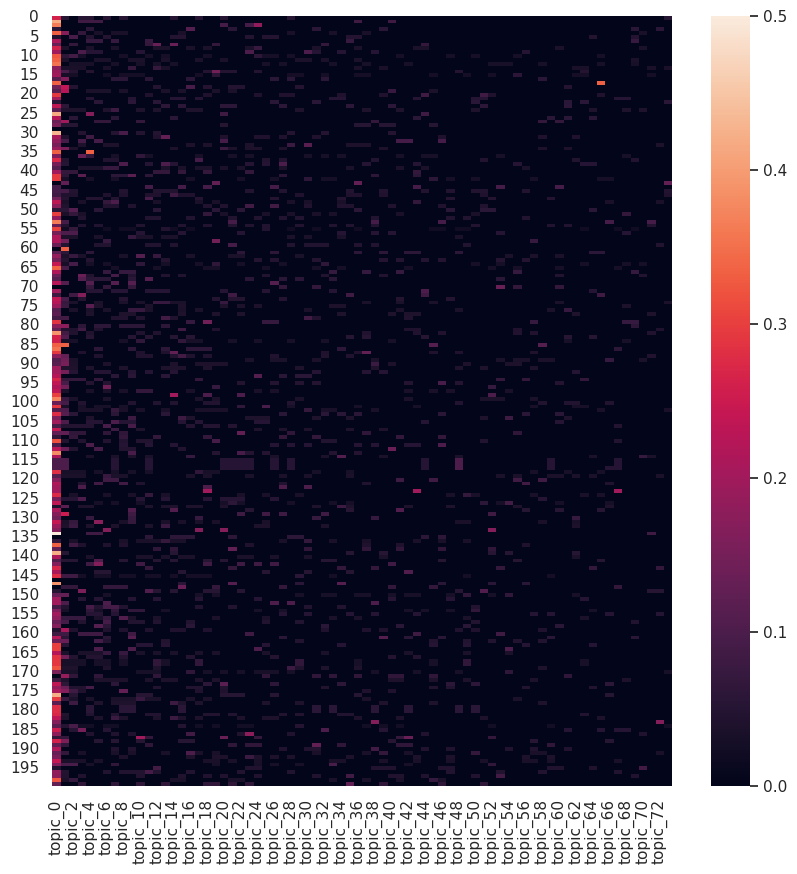

In [39]:
# heatmap of percent of topics in a paragraph
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(norm_topic_count_df.to_pandas())

In [40]:
# sns.set(rc={'figure.figsize':(20,60)})
# sns.heatmap(norm_topic_count_df.to_pandas())

In [41]:
avg_norm_topic_count_df = norm_topic_count_df.sum(axis=0) / norm_topic_count_df.shape[0]
# avg_norm_topic_count_df

<AxesSubplot: >

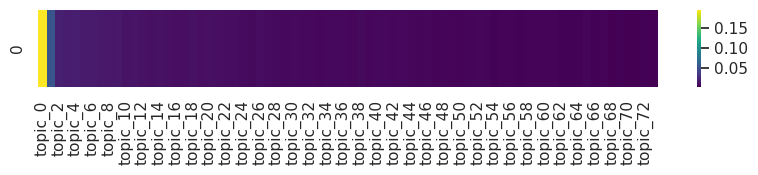

In [42]:
# heatmap of AVERAGE percent of topics in a paragraph
sns.set(rc={'figure.figsize':(10,1)})
sns.heatmap(avg_norm_topic_count_df.to_frame().T.to_pandas(), cmap=sns.color_palette("viridis", as_cmap=True))

<AxesSubplot: >

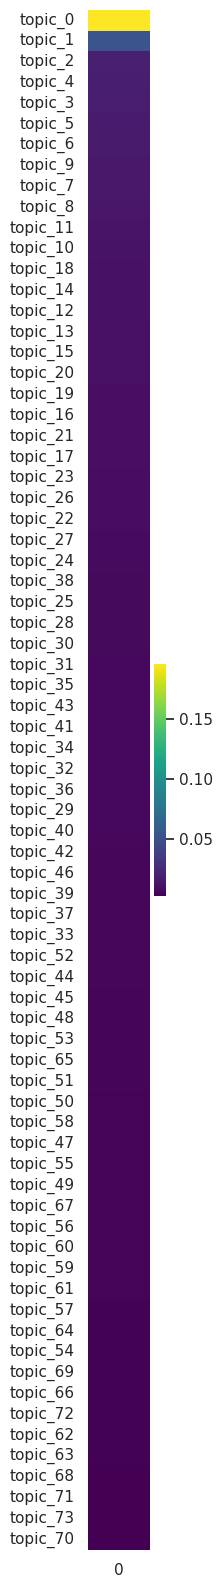

In [43]:
# heatmap of AVERAGE percent of topics in a paragraph, sorted by descending values
sns.set(rc={'figure.figsize':(1,20)})
sns.heatmap(avg_norm_topic_count_df.sort_values(ascending=False).to_frame().to_pandas(), cmap=sns.color_palette("viridis", as_cmap=True))

In [44]:
# create a variable for the name of the column that contains the labels
labels_df = df[label_col].copy().astype(int)
labels_df

0      0
1      0
2      0
3      0
4      1
      ..
195    1
196    0
197    0
198    0
199    1
Name: Recipient, Length: 200, dtype: int64

In [45]:
# fit logistic regression model
y = labels_df.to_pandas()
X = norm_topic_count_df.to_pandas()
X = sm.add_constant(X)
# reg = sm.Logit(y, X).fit(maxiter=1000, method='bfgs')
reg = sm.Logit(y, X).fit_regularized(maxiter=1000)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4775846474931757
            Iterations: 428
            Function evaluations: 428
            Gradient evaluations: 428


In [46]:
print(reg.summary())

                           Logit Regression Results                           
Dep. Variable:              Recipient   No. Observations:                  200
Model:                          Logit   Df Residuals:                      125
Method:                           MLE   Df Model:                           74
Date:                Mon, 13 Feb 2023   Pseudo R-squ.:                  0.3060
Time:                        01:04:13   Log-Likelihood:                -95.517
converged:                       True   LL-Null:                       -137.63
Covariance Type:            nonrobust   LLR p-value:                    0.1953
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0352      1.129      0.031      0.975      -2.177       2.247
topic_0        0.3246      2.522      0.129      0.898      -4.618       5.267
topic_1        5.3894      3.861      1.396      0.1

In [47]:
# get topics that are statistically significant
significant_topics_coeffs = reg.params[reg.pvalues < p_alpha]
significant_topics_coeffs

topic_13    28.597197
topic_15   -30.792088
topic_26    25.128523
topic_32   -26.699702
topic_39    23.691843
topic_49   -31.438978
topic_54    47.184751
topic_58   -41.494592
topic_64   -42.638564
topic_66   -40.606944
dtype: float64

In [48]:
# calculate odds ratios of significant topics
significant_topics_odds_ratios = np.exp(significant_topics_coeffs).sort_values()
significant_topics_odds_ratios

topic_64    3.036037e-19
topic_58    9.530766e-19
topic_66    2.315411e-18
topic_49    2.219348e-14
topic_15    4.238050e-14
topic_32    2.537855e-12
topic_39    1.946420e+10
topic_26    8.188022e+10
topic_13    2.627877e+12
topic_54    3.105109e+20
dtype: float64

In [49]:
# get odds_ratios of significant topics that decrease chances
decrease_chances_topics_odds_ratios = significant_topics_odds_ratios[significant_topics_odds_ratios < 1]
decrease_chances_topics_odds_ratios = decrease_chances_topics_odds_ratios.sort_values()
decrease_chances_topics_odds_ratios

topic_64    3.036037e-19
topic_58    9.530766e-19
topic_66    2.315411e-18
topic_49    2.219348e-14
topic_15    4.238050e-14
topic_32    2.537855e-12
dtype: float64

In [50]:
# get significant topics that decrease chances
decrease_chances_topics = decrease_chances_topics_odds_ratios.index.to_series().str.split('_').apply(lambda x: x[-1]).values.astype(int).tolist()
decrease_chances_topics = sorted(decrease_chances_topics)
decrease_chances_topics

[15, 32, 49, 58, 64, 66]

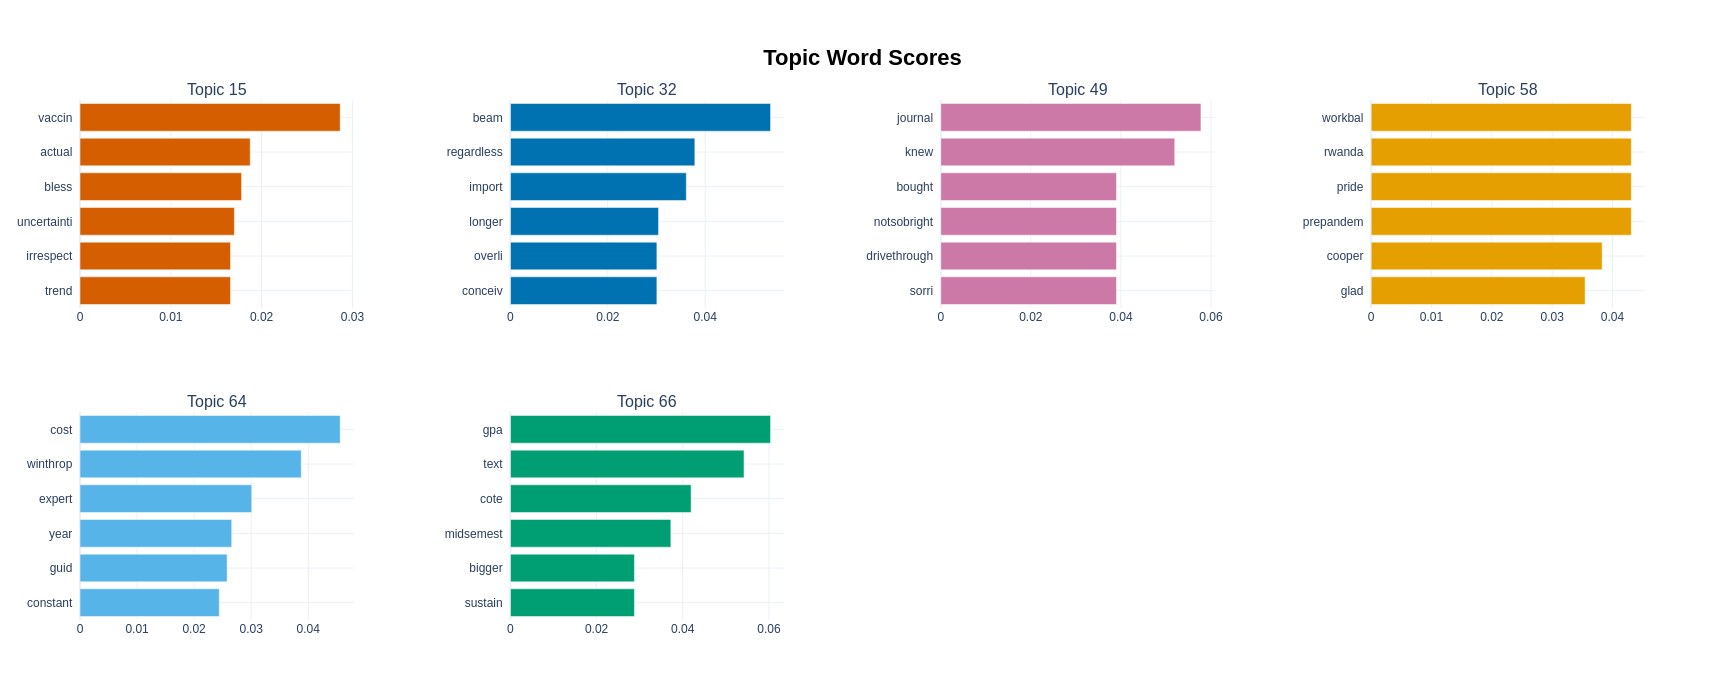

In [51]:
# plot significant topics that decrease chances
topic_model.visualize_barchart(topics=decrease_chances_topics, n_words=10, height=350, width=400)

In [52]:
# save plot of significant topics that decrease chances
topic_model.visualize_barchart(topics=decrease_chances_topics, n_words=10, height=350, width=400).write_html('./visualizations/barchart_decrease_chances_topics.html')

In [53]:
# get sentences in these topics and save a file
decrease_chances_sencs = sentences_df[senc_topics_df.astype(int).isin(decrease_chances_topics)].copy()
decrease_chances_sencs = decrease_chances_sencs.fillna('')
decrease_chances_sencs = decrease_chances_sencs.stack().reset_index(drop=True)
decrease_chances_sencs = decrease_chances_sencs[decrease_chances_sencs.str.len() > 0]
decrease_chances_sencs.to_frame().to_csv(decrease_chances_sencs_filename, index=False)
decrease_chances_sencs

200     However, I am grateful that although I was bat...
216     Due to the COVID-19 pandemic, my mother was st...
222     I was able to help pay rent and utilities by w...
303     Many people, especially in the black community...
497     All of these things greatly helped me to impro...
                              ...                        
8228        I eventually had to return to my home country
8400    In order to stay ahead of the issues related t...
8440    I made sure my routine sticks as closely to my...
8490    Presently, I can say that I have overcome my b...
8524    My world was falling apart and there wasn't an...
Length: 142, dtype: object

In [54]:
# get odds_ratios of significant topics that increase chances
increase_chances_topics_odds_ratios = significant_topics_odds_ratios[significant_topics_odds_ratios > 1]
increase_chances_topics_odds_ratios = increase_chances_topics_odds_ratios.sort_values(ascending=False)
increase_chances_topics_odds_ratios

topic_54    3.105109e+20
topic_13    2.627877e+12
topic_26    8.188022e+10
topic_39    1.946420e+10
dtype: float64

In [55]:
# get significant topics that increase chances
increase_chances_topics = increase_chances_topics_odds_ratios.index.to_series().str.split('_').apply(lambda x: x[-1]).values.astype(int).tolist()
increase_chances_topics = sorted(increase_chances_topics)
increase_chances_topics

[13, 26, 39, 54]

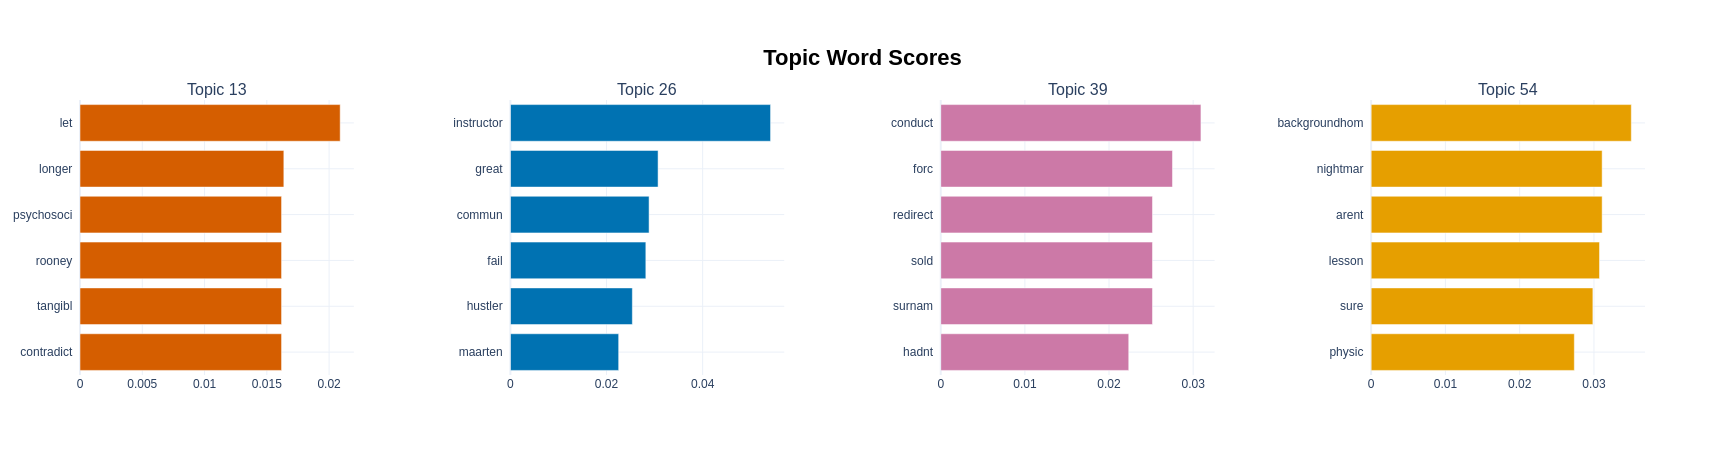

In [56]:
# plot significant topics that increase chances
topic_model.visualize_barchart(topics=increase_chances_topics, n_words=10, height=350, width=400)

In [57]:
# save plot of significant topics that increase chances
topic_model.visualize_barchart(topics=increase_chances_topics, n_words=10, height=350, width=400).write_html('./visualizations/barchart_increase_chances_topics.html')

In [58]:
# get sentences in these topics and save a file
increase_chances_sencs = sentences_df[senc_topics_df.astype(int).isin(increase_chances_topics)].copy()
increase_chances_sencs = increase_chances_sencs.fillna('')
increase_chances_sencs = increase_chances_sencs.stack().reset_index(drop=True)
increase_chances_sencs = increase_chances_sencs[increase_chances_sencs.str.len() > 0]
increase_chances_sencs.to_frame().to_csv(increase_chances_sencs_filename, index=False)
increase_chances_sencs

142     It was very difficult for me to establish a ti...
230     My dedication to not only my family but also m...
369     Andy Rooney once said and I quote "everyone wa...
435     Classrooms collected dust while Zoom became th...
445     The halls I used to comfortably navigate, I no...
                              ...                        
8319    With work, I have kept consistent communicatio...
8354         The summer after my freshman year was hectic
8394    Whether that be studying by myself or learning...
8569    I am the first one in my family to go to colle...
8570    I am continuing to strive to new heights daily...
Length: 125, dtype: object

In [59]:
# get the topics that decrease chances the most (ignoring statistical significance)
bottom_k_topics = reg.params.sort_values()[:k_topics].index.to_series().str.split('_').apply(lambda x: x[-1]).astype(int).tolist()
bottom_k_topics

[64, 58, 66, 73, 57]

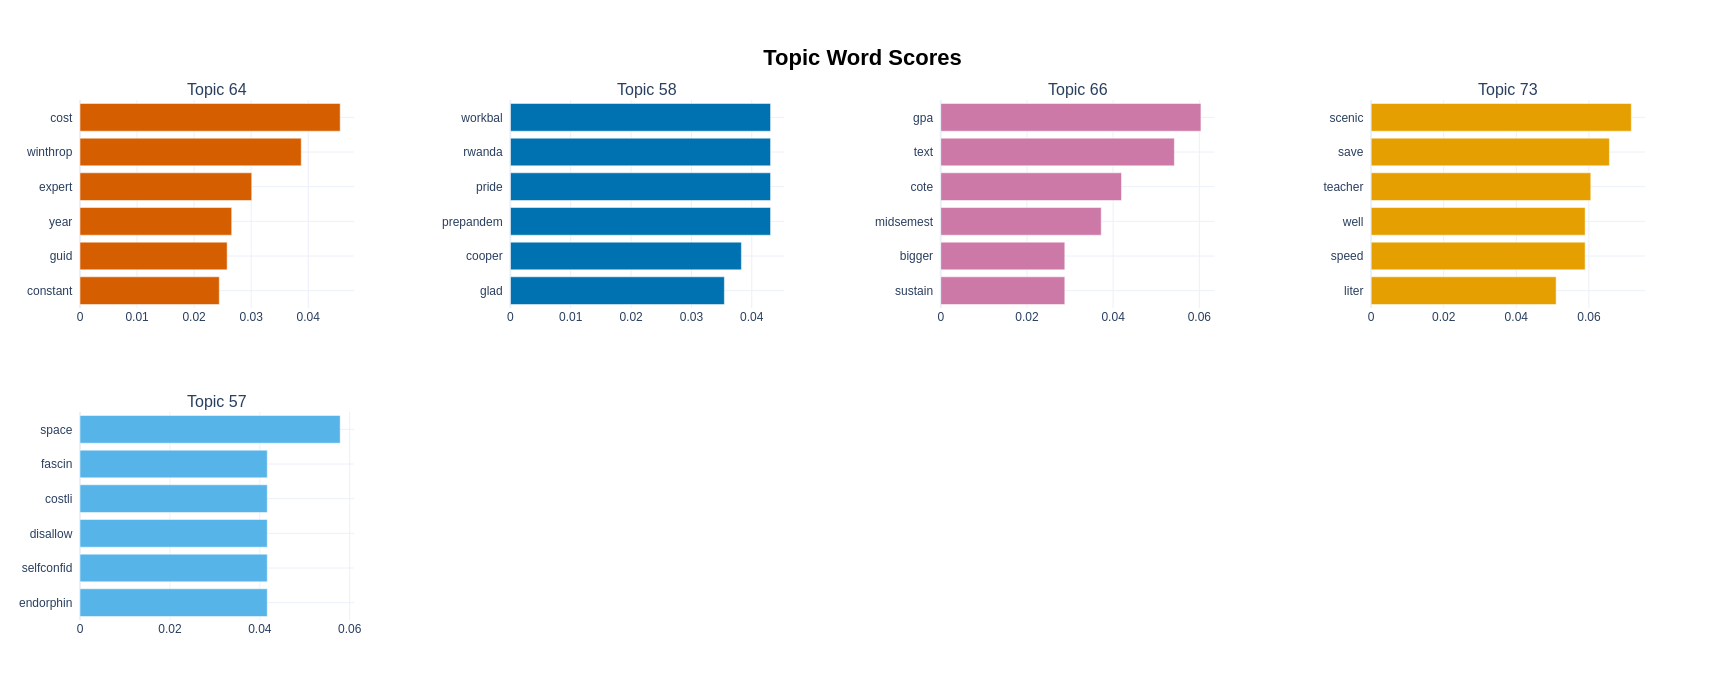

In [60]:
# plot topics that decrease chances the most (ignoring statistical significance)
topic_model.visualize_barchart(topics=bottom_k_topics, n_words=10, height=350, width=400)

In [61]:
# save plot of significant topics that increase chances
topic_model.visualize_barchart(topics=bottom_k_topics, n_words=10, height=350, width=400).write_html('./visualizations/barchart_bottom_k_topics.html')

In [62]:
# get sentences in these topics and save a file
bottom_k_sencs = sentences_df[senc_topics_df.astype(int).isin(bottom_k_topics)].copy()
bottom_k_sencs = bottom_k_sencs.fillna('')
bottom_k_sencs = bottom_k_sencs.stack().reset_index(drop=True)
bottom_k_sencs = bottom_k_sencs[bottom_k_sencs.str.len() > 0]
bottom_k_sencs.to_frame().to_csv(bottom_k_sencs_filename, index=False)
bottom_k_sencs

12      I became more computer literate, got better at...
222     I was able to help pay rent and utilities by w...
522                    I am getting this degree on my own
569     To manage these drastic changes and nightly re...
704                                         I overcame it
                              ...                        
8223    I had limited options and no budget for unanti...
8228        I eventually had to return to my home country
8305    It was not an easy time for me during that period
8400    In order to stay ahead of the issues related t...
8440    I made sure my routine sticks as closely to my...
Length: 73, dtype: object

In [63]:
# get the topics that increase chances the most (ignoring statistical significance)
top_k_topics = reg.params.sort_values(ascending=False)[:k_topics].index.to_series().str.split('_').apply(lambda x: x[-1]).astype(int).tolist()
top_k_topics

[54, 71, 13, 61, 56]

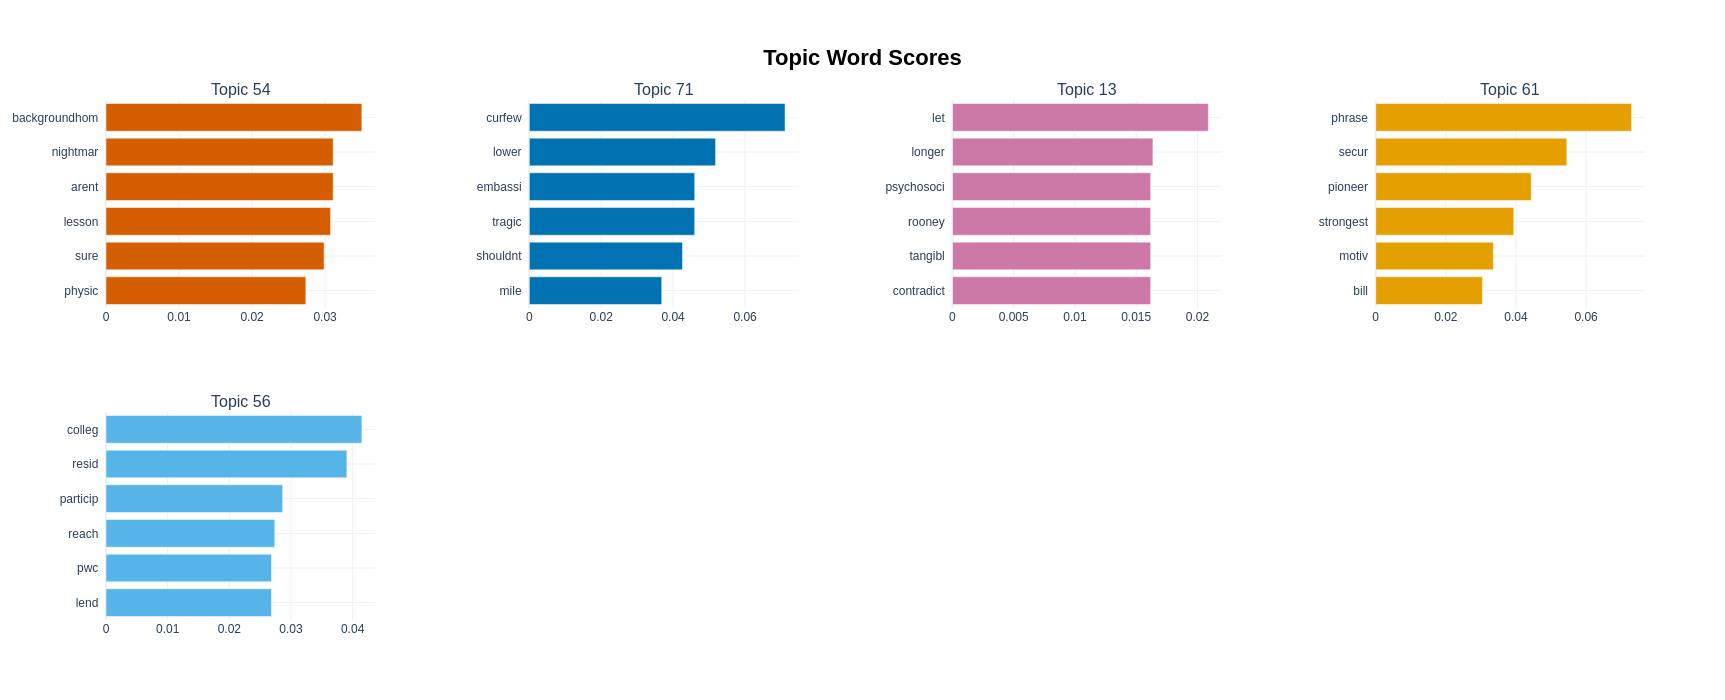

In [64]:
# plot topics that increase chances the most (ignoring statistical significance)
topic_model.visualize_barchart(topics=top_k_topics, n_words=10, height=350, width=400)

In [65]:
# save plot of significant topics that increase chances
topic_model.visualize_barchart(topics=top_k_topics, n_words=10, height=350, width=400).write_html('./visualizations/barchart_top_k_topics.html')

In [66]:
# get sentences in these topics and save a file
top_k_sencs = sentences_df[senc_topics_df.astype(int).isin(top_k_topics)].copy()
top_k_sencs = top_k_sencs.fillna('')
top_k_sencs = top_k_sencs.stack().reset_index(drop=True)
top_k_sencs = top_k_sencs[top_k_sencs.str.len() > 0]
top_k_sencs.to_frame().to_csv(top_k_sencs_filename, index=False)
top_k_sencs

369     Andy Rooney once said and I quote "everyone wa...
403     At the beginning of my second year of college,...
445     The halls I used to comfortably navigate, I no...
490     Still struggling with my mental health, I want...
538     I want a quality education so I can to help hi...
                              ...                        
8183      Thirdly, I began to plan and use my time wisely
8216    With so many unknowns and contradicting resear...
8258    In high school, I found it easy to form relati...
8320    Additionally, I have enrolled in my general ed...
8570    I am continuing to strive to new heights daily...
Length: 109, dtype: object